Written by Ye-seul Oh. 

# <span style="color:blue">2 HOMO-LUMO gap 예측 ~ **<< Descriptors >>**</span>

## <span style="color:orange">HOMO-LUMO gap을 예측하는데 고려해볼만한 요소들 → feature로 사용</span>
<span style="color:blue"><1></span> Oscillator strength  
- 빛이 얼마나 흡수되는 지와 관련

<span style="color:blue"><2></span> Conjugation  
- conjugated groups의 개수   
    .rdchem **.GetNumConjGrps**((ResonanceMolSupplier)arg1) → int 
- Aromatic ring의 개수    
    .rdMolDescriptors **.CalcNumAromaticRings**((Mol)mol) → int     

<span style="color:blue"><3></span> EDG와 EWG 
- functional gourps의 개수  
    **identify_functional_groups**(mol) →  list   
    <span style="color:green">(※refernce※ 링크 참조  -  분자의 functional group의 정보를 리스트로 반환하는 mehod.</span>   
    <span style="color:green">따라서 리스트 요소 개수 = 작용기 개수)</span>   

<span style="color:blue"><4></span> Atom 
- Hetero atom의 개수  
    .rdMolDescriptors **.CalcNumHeteroatoms**((Mol)mol) → int

<span style="color:blue"><5></span> Hardness/Softness   
<span style="color:green">직접 계산하는 method 못찾음. mendeleev package에 hardness() 찾았지만 Atom에 한정.  
    ↓ Hardness/Softness에 영향을 주는 요소들을 대신함.</span>  
- 전기 음성도
- 편극성  
    .Descriptors **.MaxPartialCharge**(mol, force=False) → float  
    .Descriptors **.MinPartialCharge**(mol, force=False) → float  
- 산화수  
- 크기 (volume, diameter, radius)   
    .AllChem.**ComputeMolVolume**(mol) <span style="color:green">(얘는 이렇게 저렇게 해봐도 돌려도 오류뜸.. 뭘 잘못했는지 모르겠음.)</span>  

※reference※
- https://chemiolin.tistory.com/2
- http://chemical-quantum-images.blogspot.com/2018/11/electron-donating-and-withdrawing-groups.html 
- https://github.com/rdkit/rdkit/tree/master/Contrib/IFG  
- https://www.shodor.org/chemviz/ionization/students/hardness.html

## +추가로 여러가지  
**rd mol descriptors**  
Molecular Weight → CalcExactMolWt(mol)
rdkit.Chem.rdMolDescriptors.CalcNumLipinskiHBA((Mol)mol) → int   
rdkit.Chem.rdMolDescriptors.CalcNumLipinskiHBD((Mol)mol) → int  
rdkit.Chem.rdMolDescriptors.CalcNumRotatableBonds((Mol)mol) → int 
rdkit.Chem.rdMolDescriptors.CalcNumRings((Mol)mol) → int   
rdkit.Chem.rdMolDescriptors.CalcNumHeterocycles((Mol)mol) → int    
rdkit.Chem.rdMolDescriptors.CalcNumSaturatedRings((Mol)mol) → int   
rdkit.Chem.rdMolDescriptors.CalcNumAliphaticRings((Mol)mol) → int   
rdkit.Chem.rdMolDescriptors.CalcNumBridgeheadAtoms((Mol)mol) → int   

**descriptors**  
rdkit.Chem.Descriptors.NumValenceElectrons(mol)

**fragments**  
rdkit.Chem.Fragments.fr_C_O(mol) → int  
rdkit.Chem.Fragments.fr_ArN(mol) → int
rdkit.Chem.Fragments.fr_methoxy(mol) → int  

 +전체 descriptors 다 계산해보기  
rdkit.ML.Descriptors.**MoleculeDescriptors** module  → 나중에 이런 모듈의 method를 for 문으로 돌려봐야겠음. 
https://www.rdkit.org/docs/source/rdkit.ML.Descriptors.MoleculeDescriptors.html 

# <span style="color:blue">Let's start ~ !</span>

### <span style="color:orange">Maching Learning 기본 순서</span>
1. **전체 dataset을 준비**
2. X , y 분리
3. traing set , test set 분리
---
4. 빈 모델을 만듦
5. 빈 모델에 traing set을 넣어 모델을 학습시킴
6. 학습된 모델에 test set을 넣어 예측시켜봄
---
7. 잘 풀었나 채점해봄 
8. 모델 튜닝 Hypter parameter
9. 어떤 feature가 중요했는지 확인 

In [2]:
import rdkit  
from rdkit import Chem  
import pandas as pd
import rdkit.Chem.rdMolDescriptors as rdMD
from rdkit.Chem import AllChem
import rdkit.Chem.Fragments as Fm
from rdkit.Chem.Descriptors import MaxPartialCharge, MinPartialCharge, NumValenceElectrons

In [3]:
HO_LU=pd.read_csv('PubchemQC_Random_HOMO-LUMO_gap_and_OS.csv')

In [5]:
HO_LU

,#HOMO-LUMO_gap(eV),Oscillator_Strength,SMILES
0,4.603,0.053,CC(C)(C1=CC(=C(C=C1)F)N2CCNCC2)O
1,3.980,0.002,CC1CC(C(=O)C(O1)C)(C)N
2,4.958,0.003,CC1(CC(CC(N1O)(C)C)[N+](C)(C)C)C
3,4.822,0.065,C1=CC(=C(C=C1CC(C(=O)O)N)O)O
4,4.104,0.110,CC(CNC1=NC=NC2=CC=CC=C21)C(=O)O
...,...,...,...
99995,5.333,0.003,CN1CCCC1C(=O)NCC2CCCO2
99996,4.448,0.002,C1COC(=N)N=C1
99997,3.606,0.000,CC12CCC(=O)C=C1CCC3C2CCC4(C3CCC4(C#C)O)C
99998,0.000,0.000,C(CO)NC[CH]O


### <span style="color:red">**↓**</span>

In [5]:
# 이것은 identify_functional_groups() method를 사용하기 위해 실행시켜야 한다. 누군가가 짜놓은 코드. (※reference 참조※)
from rdkit import Chem
from collections import namedtuple

def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('A=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def identify_functional_groups(mol):
    marked = set()
#mark all heteroatoms in a molecule, including halogens
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in (6,1): # would we ever have hydrogen?
            marked.add(atom.GetIdx())

#mark the four specific types of carbon atom
    for patt in PATT_TUPLE:
        for path in mol.GetSubstructMatches(patt):
            for atomindex in path:
                marked.add(atomindex)

#merge all connected marked atoms to a single FG
    groups = []
    while marked:
        grp = set([marked.pop()])
        merge(mol, marked, grp)
        groups.append(grp)

#extract also connected unmarked carbon atoms
    ifg = namedtuple('IFG', ['atomIds', 'atoms', 'type'])
    ifgs = []
    for g in groups:
        uca = set()
        for atomidx in g:
            for n in mol.GetAtomWithIdx(atomidx).GetNeighbors():
                if n.GetAtomicNum() == 6:
                    uca.add(n.GetIdx())
        ifgs.append(ifg(atomIds=tuple(list(g)), atoms=Chem.MolFragmentToSmiles(mol, g, canonical=True), type=Chem.MolFragmentToSmiles(mol, g.union(uca),canonical=True)))
    return ifgs

def main():
    for ix, smiles in enumerate([
        'Cc1nc(NS(=O)(=O)c2ccc(N)cc2)nc(C)c1', # fig1, 1
        'NC(=N)c1ccc(C=Cc2ccc(cc2O)C(=N)N)cc1', # 2
        'CC(=O)Nc1nnc(s1)S(=O)(=O)N', # 3
        'NS(=O)(=O)c1cc2c(NCNS2(=O)=O)cc1Cl', # 4
        'CNC1=Nc2ccc(Cl)cc2C(=N(=O)C1)c3ccccc3', # 5
        'Cc1onc(c1C(=O)NC2C3SC(C)(C)C(N3C2=O)C(=O)O)c4ccccc4', # 6
        'Clc1ccccc1C2=NCC(=O)Nc3ccc(cc23)N(=O)=O', # 7
        'COc1cc(cc(C(=O)NCC2CCCN2CC=C)c1OC)S(=O)(=O)N', # 8
        'Cc1ccc(Cl)c(Nc2ccccc2C(=O)O)c1Cl', # 9
        'Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1', # 10 - there is a discrepancy with the paper here!  I wonder if Peter has the ring as aromatic?
        'FC(F)(F)CN1C(=O)CN=C(c2ccccc2)c3cc(Cl)ccc13', # 11
        'OCC1OC(CC1O)n2cnc3C(O)CNC=Nc32', # 12
        'CCNC1CC(C)S(=O)(=O)c2sc(cc12)S(=O)(=O)N', # 13
        'CC(O)C1C2C(C)C(=C(N2C1=O)C(=O)O)SC3CNC(C3)C(=O)N(C)C', # 14
        'CC1CN(CC(C)N1)c2c(F)c(N)c3c(=O)c(cn(C4CC4)c3c2F)C(=O)O', # 15
        'CC(=CCC1C(=O)N(N(C1=O)c2ccccc2)c3ccccc3)C', # 16
        'Clc1ccc2N=C3NC(=O)CN3Cc2c1Cl', # 17
        'CC(=O)NC1C(NC(=N)N)C=C(OC1C(O)C(O)CO)C(=O)O', # 18
        'CC(O)C(O)C1CNc2nc(N)nc(O)c2N1', # 19
        'NC1CCCCN(C1)c2c(Cl)cc3c(=O)c(cn(C4CC4)c3c2Cl)C(=O)O', # 20
    ]):
        m = Chem.MolFromSmiles(smiles)
        fgs = identify_functional_groups(m)
        print('%2d: %d fgs'%(ix+1, len(fgs)), fgs)


if __name__ == "__main__":
    main()

 1: 4 fgs [IFG(atomIds=(2,), atoms='n', type='cnc'), IFG(atomIds=(4, 5, 6, 7), atoms='NS(=O)=O', type='cNS(c)(=O)=O'), IFG(atomIds=(12,), atoms='N', type='cN'), IFG(atomIds=(15,), atoms='n', type='cnc')]
 2: 4 fgs [IFG(atomIds=(0, 1, 2), atoms='N=CN', type='cC(=N)N'), IFG(atomIds=(8, 7), atoms='C=C', type='cC=Cc'), IFG(atomIds=(15,), atoms='O', type='cO'), IFG(atomIds=(16, 17, 18), atoms='N=CN', type='cC(=N)N')]
 3: 4 fgs [IFG(atomIds=(1, 2, 3), atoms='NC=O', type='cNC(C)=O'), IFG(atomIds=(5, 6), atoms='nn', type='cnnc'), IFG(atomIds=(8,), atoms='s', type='csc'), IFG(atomIds=(9, 10, 11, 12), atoms='NS(=O)=O', type='cS(N)(=O)=O')]
 4: 3 fgs [IFG(atomIds=(0, 1, 2, 3), atoms='NS(=O)=O', type='cS(N)(=O)=O'), IFG(atomIds=(8, 9, 10, 11, 12, 13), atoms='NCNS(=O)=O', type='O=S1(=O)ccNCN1'), IFG(atomIds=(16,), atoms='Cl', type='cCl')]
 5: 3 fgs [IFG(atomIds=(1, 2, 3), atoms='N=CN', type='cN=C(C)NC'), IFG(atomIds=(8,), atoms='Cl', type='cCl'), IFG(atomIds=(11, 12, 13), atoms='C=[N+][O-]', type='

In [8]:
# 계산해 볼 값 
cj = []   # conjugated 
arr = []  # aromatic
fg = []  # functional
ha = [] # hetero  
max_pc = [] # max partial charge
min_pc =[]  # min partial charge
#mv = [] #molecuole

# +추가적으로 계산해 볼  값들
mw = []
hba = []
hbd = []
rb = []
r = []
hc = []
sr = []
alr = []
ba = []

ve = []

co = []
arn = []
mth = []


# 분자를 차례로 반복하면서 특징 값을 계산. 
for smi in HO_LU['SMILES']:
    m = Chem.MolFromSmiles(smi)
    m2 = Chem.ResonanceMolSupplier(m)
    cj.append(m2.GetNumConjGrps())   
    arr.append(rdMD.CalcNumAromaticRings(m))
    fg.append(len(identify_functional_groups(m))) # 작용기 개수를 원하므로 len()에 넣어주기!
    ha.append(rdMD.CalcNumHeteroatoms(m))
    max_pc.append(MaxPartialCharge(m))
    min_pc.append(MinPartialCharge(m))
    #mv.append(AllChem.ComputeMolVolume(m))   # 계속 오류 떠서 실행하지 않음
   
    mw.append(rdMD.CalcExactMolWt(m))
    hba.append(rdMD.CalcNumLipinskiHBA(m))
    hbd.append(rdMD.CalcNumLipinskiHBD(m))
    rb.append(rdMD.CalcNumRotatableBonds(m))
    r.append(rdMD.CalcNumRings(m))
    hc.append(rdMD.CalcNumHeterocycles(m))
    sr.append(rdMD.CalcNumSaturatedRings(m))
    alr.append(rdMD.CalcNumAliphaticRings(m))
    ba.append(rdMD.CalcNumBridgeheadAtoms(m))
    
    ve.append(NumValenceElectrons(m))
    
    co.append(Fm.fr_C_O(m))
    arn.append(Fm.fr_ArN(m))
    mth.append(Fm.fr_methoxy(m))

In [9]:
HO_LU['cj'] = cj
HO_LU['arr'] = arr
HO_LU['fg'] = fg
HO_LU['ha'] = ha
HO_LU['max_pc'] = max_pc
HO_LU['min_pc'] = min_pc
#HO_LU['mv'] = mv

HO_LU['mw'] = mw
HO_LU['hba'] = hba
HO_LU['hbd'] = hbd
HO_LU['rb'] = rb
HO_LU['r'] = r
HO_LU['hc'] = hc
HO_LU['sr'] = sr
HO_LU['alr'] = alr
HO_LU['ba'] = ba

HO_LU['ve'] = ve

HO_LU['co'] = co
HO_LU['arn'] = arn
HO_LU['mth'] = mth

In [10]:
pd.set_option('display.max_columns',None)  #전체 열 다 보기.

In [11]:
smiles = HO_LU['SMILES']        # feature들을 오른쪽에 모아주기 위해 SMILES를 잠시 빼두고
HO_LU.drop('SMILES', axis=1, inplace=True)      # dataframe에서 SMILES 열을 지우고
HO_LU.insert(0,'SMILES',smiles)            # 왼쪽에 다시 삽입했다.
HO_LU    # SMILES 가 첫번쨰 열에 온 것을 확인!

,SMILES,#HOMO-LUMO_gap(eV),Oscillator_Strength,cj,arr,fg,ha,max_pc,min_pc,mw,hba,hbd,rb,r,hc,sr,alr,ba,ve,co,arn,mth
0,CC(C)(C1=CC(=C(C=C1)F)N2CCNCC2)O,4.603,0.053,1,1,4,4,0.146012,-0.385753,238.148141,3,2,2,2,1,1,1,0,94,0,0,0
1,CC1CC(C(=O)C(O1)C)(C)N,3.980,0.002,0,0,3,3,0.180288,-0.367630,157.110279,3,2,0,1,1,1,1,0,64,1,0,0
2,CC1(CC(CC(N1O)(C)C)[N+](C)(C)C)C,4.958,0.003,0,0,2,3,0.092082,-0.328366,215.211790,3,1,1,1,1,1,1,0,90,0,0,0
3,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,4.822,0.065,2,1,4,5,0.320316,-0.504260,197.068808,5,5,3,1,0,0,0,0,76,1,0,0
4,CC(CNC1=NC=NC2=CC=CC=C21)C(=O)O,4.104,0.110,2,2,4,5,0.307501,-0.480985,231.100777,5,2,4,2,1,0,0,0,88,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CN1CCCC1C(=O)NCC2CCCO2,5.333,0.003,1,0,3,4,0.236940,-0.376386,212.152478,4,1,3,2,2,2,2,0,86,1,0,0
99996,C1COC(=N)N=C1,4.448,0.002,1,0,1,3,0.307877,-0.463489,98.048013,3,1,0,1,1,0,1,0,38,0,0,0
99997,CC12CCC(=O)C=C1CCC3C2CCC4(C3CCC4(C#C)O)C,3.606,0.000,1,0,3,2,0.155197,-0.377034,312.208930,2,1,0,4,0,3,4,0,124,1,0,0
99998,C(CO)NC[CH]O,0.000,0.000,0,0,3,3,0.093513,-0.395054,104.071154,3,3,4,0,0,0,0,0,43,0,0,0


###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. 전체 dataset을 준비
2. **X , y 분리**
3. **traing set , test set 분리**<span style="color:orange"> →  X_train, X_test, y_train, y_test</span>
---
4. 빈 모델을 만듦
5. 빈 모델에 traing set을 넣어 모델을 학습시킴
6. 학습된 모델에 test set을 넣어 예측시켜봄
---
7. 잘 풀었나 채점해봄 
8. 모델 튜닝 Hypter parameter
9. 어떤 feature가 중요했는지 확인 

In [12]:
X = HO_LU.iloc[:,2:]      #feature는 3열부터 왼쪽 끝까지의 열이다.
y = HO_LU.iloc[:,1]       #target(output)은 2열이다.

In [13]:
X  

,Oscillator_Strength,cj,arr,fg,ha,max_pc,min_pc,mw,hba,hbd,rb,r,hc,sr,alr,ba,ve,co,arn,mth
0,0.053,1,1,4,4,0.146012,-0.385753,238.148141,3,2,2,2,1,1,1,0,94,0,0,0
1,0.002,0,0,3,3,0.180288,-0.367630,157.110279,3,2,0,1,1,1,1,0,64,1,0,0
2,0.003,0,0,2,3,0.092082,-0.328366,215.211790,3,1,1,1,1,1,1,0,90,0,0,0
3,0.065,2,1,4,5,0.320316,-0.504260,197.068808,5,5,3,1,0,0,0,0,76,1,0,0
4,0.110,2,2,4,5,0.307501,-0.480985,231.100777,5,2,4,2,1,0,0,0,88,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.003,1,0,3,4,0.236940,-0.376386,212.152478,4,1,3,2,2,2,2,0,86,1,0,0
99996,0.002,1,0,1,3,0.307877,-0.463489,98.048013,3,1,0,1,1,0,1,0,38,0,0,0
99997,0.000,1,0,3,2,0.155197,-0.377034,312.208930,2,1,0,4,0,3,4,0,124,1,0,0
99998,0.000,0,0,3,3,0.093513,-0.395054,104.071154,3,3,4,0,0,0,0,0,43,0,0,0


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=722)

###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. 전체 dataset을 준비
2. X , y 분리
3. traing set , test set 분리
---
4. **빈 모델을 만듦**
5. **빈 모델에 traing set을 넣어 모델을 학습시킴**
6. **학습된 모델에 test set을 넣어 예측시켜봄** 
---
7. 잘 풀었나 채점해봄 
8. 모델 튜닝 Hypter parameter
9. 어떤 feature가 중요했는지 확인 

In [16]:
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

In [17]:
ys_model = RandomForestRegressor()    #빈 회귀 모델을 만들었다.

In [ ]:
ys_model.fit(X_train, y_train)       #연습문제와 답을 넣어 학습시킨다. 

↑ 데이터 사이즈가 커서 실행이 안된다. (오류: NaN문제가 아님을 dropna() method로 확인했다. 아무래도 큰 데이터가 문제인것 같다.)

↓ Oscillator strength feature와 19개의 나머지 feature중 4개를 골라서 오차를 가장 낮추는 feature조합이 무엇인지 반환하도록 해보았다. (Combination: 19C4)

In [26]:
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error

min_r_mse = 1.0
for i in product(range(3,22), range(3,22), range(3,22), range(3,22)):   # 조합 함수.
    X = HO_LU.iloc[:,[2,i[0],i[1],i[2],i[3]]]     
    y = HO_LU.iloc[:,1]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=722)
    ys_model = RandomForestRegressor()      
    ys_model.fit(X_train, y_train)        
    y_pred = ys_model.predict(X_test)
    r_mse = sqrt(mean_squared_error(y_test, y_pred))
    if r_mse < min_r_mse:      # 기존의 최소 오차보다 작아졌을 때 
        min_r_mse = r_mse
        min_features = i
        print(r_mse)
        
print(f"오차: {min_r_mse}")
print(f"오차를 가장 낮추는 feature는 2열 + {i} 열 의 조합이다.")

0.8251315968514696
0.796699367552995


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

↑ 실행이 멈춰버렸다. (노트북 사양이 낮아서 그런 것 같다...)  

↓ 이번엔 feature를 고르는 대신 total molecule set를 [one to ten] 으로 쪼개서 각각 돌려보기로 했다.

In [28]:
one = HO_LU.iloc[:10000]
two = HO_LU.iloc[10001:20000]
three = HO_LU.iloc[20001:30000]
four = HO_LU.iloc[30001:40000]
five = HO_LU.iloc[40001:50000]
six = HO_LU.iloc[50001:60000]
seven = HO_LU.iloc[60001:70000]
eight = HO_LU.iloc[70001:80000]
nine = HO_LU.iloc[80001:90000]
ten = HO_LU.iloc[90001:100000]

위에서 나눈 molecule set들을 for문으로 돌려서 오차를 반환하도록 하는 코드를 짰는데 그것도 과부하가 걸렸다...  
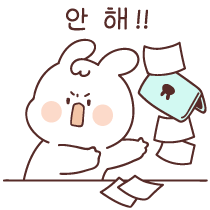

↓ 단계별로 나눠서 실행시키기로 했다. for문으로 moecule sets 순서대로 X_train, X_test, y_train, y_test 값을 받는 리스트를 생성한 후  
(예: list_X_i_train 의 첫번째 요소는 molecule set one의  X_train 값)

In [160]:
HO_LU_list=[one,two,three,four,five,six,seven,eight,nine,ten]

list_X_i = []
list_y_i = []

list_X_i_train = []
list_X_i_test = []
list_y_i_train = []
list_y_i_test = []

list_y_i_pred = []

list_r_mse_i = [] 

for i in range(0,10):
    X_i = HO_LU_list[i].iloc[:,2:]    
    y_i = HO_LU_list[i].iloc[:,1]
    list_X_i.append(X_i)
    list_y_i.append(y_i)

    X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(list_X_i[i],list_y_i[i],test_size=0.2,random_state=722)
    list_X_i_train.append(X_i_train)
    list_X_i_test.append(X_i_test)
    list_y_i_train.append(y_i_train)
    list_y_i_test.append(y_i_test)

↓ for문으로 한번에 학습시키기 오류...

In [ ]:
for i in range(0,10):
    ys_model.fit(list_X_i_train[i], list_y_i_train[i])   # ERROR

↓ 직접 molecule set 하나씩 학습시켰다.

In [148]:
ys_model.fit(list_X_i_train[0], list_y_i_train[0])

RandomForestRegressor()

In [ ]:
ys_model.fit(list_X_i_train[1], list_y_i_train[1])  # ERROR

In [ ]:
ys_model.fit(list_X_i_train[2], list_y_i_train[2])   # ERROR

In [151]:
ys_model.fit(list_X_i_train[3], list_y_i_train[3])

RandomForestRegressor()

In [ ]:
ys_model.fit(list_X_i_train[4], list_y_i_train[4])   # ERROR

In [ ]:
ys_model.fit(list_X_i_train[5], list_y_i_train[5])   # ERROR

In [ ]:
ys_model.fit(list_X_i_train[6], list_y_i_train[6])  # ERROR

In [155]:
ys_model.fit(list_X_i_train[7], list_y_i_train[7])

RandomForestRegressor()

In [156]:
ys_model.fit(list_X_i_train[8], list_y_i_train[8])

RandomForestRegressor()

In [ ]:
ys_model.fit(list_X_i_train[9], list_y_i_train[9])  # ERROR

↑ 제대로 실행된 molecule set은 idx [0],[3],[7],[8] 4개이다.

↓ 예측하기!

In [161]:
for i in [0,3,7,8]:
    y_pred_i = ys_model.predict(list_X_i_test[i])
    list_y_i_pred.append(y_pred_i)  

In [162]:
len(list_y_i_pred)

4

↑ 실행이 완료 되었다.

###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. 전체 dataset을 준비
2. X , y 분리
3. traing set , test set 분리
---
4. 빈 모델을 만듦
5. 빈 모델에 traing set을 넣어 모델을 학습시킴
6. 학습된 모델에 test set을 넣어 예측시켜봄
---
7. **잘 풀었나 채점해봄** → 그래프 그려보기, 오차를 정량화
8. 모델 튜닝 Hypter parameter
9. 어떤 feature가 중요했는지 확인 

↓ 정답과 예측값을 비교해야하므로 y_test 리스트에서 idx [0],[3],[7],[8] 만 뽑아준다.

In [163]:
new_list_y_i_test = []
for i in [0,3,7,8]:
    new_list_y_i_test.append(list_y_i_test[i])
len(new_list_y_i_test)

4

♠ 그래프 그려보기

In [105]:
import matplotlib.pyplot as plt  
%matplotlib inline

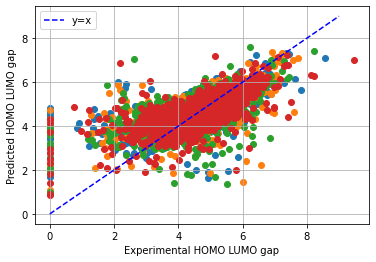

In [164]:
for i in range(0,4):
    plt.scatter(new_list_y_i_test[i], list_y_i_pred[i])
plt.xlabel("Experimental HOMO LUMO gap")
plt.ylabel("Predicted HOMO LUMO gap")
plt.grid()
plt.plot(range(0, 10), range(0, 10), "b--", label = "y=x")   #plt.plot() 선형 그래프 # x값 4~11, y값 4~11
plt.legend()

♠ 오차 계산

In [165]:
for i in range(0,4):
    r_mse_i = sqrt(mean_squared_error(new_list_y_i_test[i], list_y_i_pred[i]))    # MSE(평균 제곱 오차)에 루트를 씌워 RMSD(평균 제굽근 오차)를 구함.
    list_r_mse_i.append(r_mse_i)
    
print(list_r_mse_i) 

[0.6733331188669665, 0.6664155192197457, 0.6828120664309412, 0.6531091076359543]


↓ 4개의 molecule set RMSE의 평균을 구했다.

In [166]:
import numpy as np
mean_r_mse = np.mean(list_r_mse_i)
mean_r_mse

0.6689174530384019

↑ 오차가 계산되었다.  
<span style="color:purple">[caculate 1] n_estimators=100 / min_samples_split=2 / RMSD = 0.6689174530384019 </span>

###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. 전체 dataset을 준비
2. X , y 분리
3. traing set , test set 분리
---
4. 빈 모델을 만듦
5. 빈 모델에 traing set을 넣어 모델을 학습시킴
6. 학습된 모델에 test set을 넣어 예측시켜봄
---
7. 잘 풀었나 채점해봄 
8. **모델 튜닝 Hypter parameter**
9. 어떤 feature가 중요했는지 확인

↓  Hyper parameter를 조정해 보았다.  
<span style="color:purple">[calculation 2]</span>

In [180]:
Nlist_y_i_pred = []
Nlist_r_mse_i =[]
min_r_mse_i = 0.7

for i in [0,3,7,8]:       # 위에서 쪼갠 molecule set 중 one, four, eight, nine 만 .fit() 가 실행되므로 해당 set들만 계산이 돌아가도록 설정해주고
    for est in [100,125,275,300]:      
        for spl in [3,4]:
            model = RandomForestRegressor(n_estimators = est ,min_samples_split = spl)    # 여러 hyper parameter를 넣어볼 모델을 만들고
            model.fit(list_X_i_train[i], list_y_i_train[i])     # 학습시키기!
            y_pred_i = model.predict(list_X_i_test[i])         # 예측하기!
            Nlist_y_i_pred.append(y_pred_i)                    # 4개의 molecule set을 따로 돌렸으므로 예측값들을 리스트에 넣어주고
            for i in range(0,4):                               
                r_mse_i = sqrt(mean_squared_error(new_list_y_i_test[i], list_y_i_pred[i]))    # 4개의 molecule set들 각각의 정답과 예측 값의 RMSE를 리스트에 넣어주고
                list_r_mse_i.append(r_mse_i)    
                Nmean_r_mse_i = np.mean(list_r_mse_i)    # 구한 4개의 RMSE의 평균을 구한다.

                if Nmean_r_mse_i < min_r_mse_i :      #  hyper parameter를 바꿔가며 구한 RMSE 평균의 최소값을 구한다.
                    min_r_mse_i = Nmean_r_mse_i
                    min_est = est
                    min_spl = spl               

                print(f"n_estimators: {est}\tmin_samples_split: {spl}\tNmean_r_mse_i: {Nmean_r_mse_i}")
print("---------End of Calculation!---------")
print(f"min_est: {min_est}\tmin_spl: {min_spl}\tmin_r_mse_i: {min_r_mse_i}")  

n_estimators: 100	min_samples_split: 3	Nmean_r_mse_i: 0.6698005862041148
n_estimators: 100	min_samples_split: 3	Nmean_r_mse_i: 0.6694928528418994
n_estimators: 100	min_samples_split: 3	Nmean_r_mse_i: 0.670602787307653
n_estimators: 100	min_samples_split: 3	Nmean_r_mse_i: 0.6692571196405992
n_estimators: 100	min_samples_split: 4	Nmean_r_mse_i: 0.6695482624424827
n_estimators: 100	min_samples_split: 4	Nmean_r_mse_i: 0.6693394128943002
n_estimators: 100	min_samples_split: 4	Nmean_r_mse_i: 0.6701814537403401
n_estimators: 100	min_samples_split: 4	Nmean_r_mse_i: 0.6691771980871409
n_estimators: 125	min_samples_split: 3	Nmean_r_mse_i: 0.6694080825749089
n_estimators: 125	min_samples_split: 3	Nmean_r_mse_i: 0.6692505792404266
n_estimators: 125	min_samples_split: 3	Nmean_r_mse_i: 0.6699286535999524
n_estimators: 125	min_samples_split: 3	Nmean_r_mse_i: 0.669127722839762
n_estimators: 125	min_samples_split: 4	Nmean_r_mse_i: 0.6693188772046349
n_estimators: 125	min_samples_split: 4	Nmean_r_mse_i:

<span style="color:purple">↑ [caculate 2] n_estimators=300 / min_samples_split=4 / RMSD = 0.6689496841758367 </span>

<span style="color:purple">[calculation 3]</span>

In [182]:
Nlist_y_i_pred = []
Nlist_r_mse_i =[]
min_r_mse_i = 0.7

for i in [0,3,7,8]:       # 위에서 쪼갠 molecule set 중 one, four, eight, nine 만 .fit() 가 실행되므로 해당 set들만 계산이 돌아가도록 설정해주고
    for est in [25,50,75,100,125,150,175,200,225,250,275,300]:      
        for spl in [2,3,4,5]:
            model = RandomForestRegressor(n_estimators = est ,min_samples_split = spl)    # 여러 hyper parameter를 넣어볼 모델을 만들고
            model.fit(list_X_i_train[i], list_y_i_train[i])     # 학습시키기!
            y_pred_i = model.predict(list_X_i_test[i])         # 예측하기!
            Nlist_y_i_pred.append(y_pred_i)                    # 4개의 molecule set을 따로 돌렸으므로 예측값들을 리스트에 넣어주고
            for i in range(0,4):                               
                r_mse_i = sqrt(mean_squared_error(new_list_y_i_test[i], list_y_i_pred[i]))    # 4개의 molecule set들 각각의 정답과 예측 값의 RMSE를 리스트에 넣어주고
                list_r_mse_i.append(r_mse_i)    
                Nmean_r_mse_i = np.mean(list_r_mse_i)    # 구한 4개의 RMSE의 평균을 구한다.

                if Nmean_r_mse_i < min_r_mse_i :      #  hyper parameter를 바꿔가며 구한 RMSE 평균의 최소값을 구한다.
                    min_r_mse_i = Nmean_r_mse_i
                    min_est = est
                    min_spl = spl               

                print(f"n_estimators: {est}\tmin_samples_split: {spl}\tNmean_r_mse_i: {Nmean_r_mse_i}")
print("---------End of Calculation!---------")
print(f"min_est: {min_est}\tmin_spl: {min_spl}\tmin_r_mse_i: {min_r_mse_i}") 

n_estimators: 25	min_samples_split: 2	Nmean_r_mse_i: 0.6689814481953376
n_estimators: 25	min_samples_split: 2	Nmean_r_mse_i: 0.6689629882746498
n_estimators: 25	min_samples_split: 2	Nmean_r_mse_i: 0.6690619102614805
n_estimators: 25	min_samples_split: 2	Nmean_r_mse_i: 0.6689487698173278
n_estimators: 25	min_samples_split: 3	Nmean_r_mse_i: 0.6689796455148604
n_estimators: 25	min_samples_split: 3	Nmean_r_mse_i: 0.6689617145617478
n_estimators: 25	min_samples_split: 3	Nmean_r_mse_i: 0.6690578975608394
n_estimators: 25	min_samples_split: 3	Nmean_r_mse_i: 0.668947905906185
n_estimators: 25	min_samples_split: 4	Nmean_r_mse_i: 0.6689779416113959
n_estimators: 25	min_samples_split: 4	Nmean_r_mse_i: 0.6689605101665548
n_estimators: 25	min_samples_split: 4	Nmean_r_mse_i: 0.6690541017629357
n_estimators: 25	min_samples_split: 4	Nmean_r_mse_i: 0.6689470883795332
n_estimators: 25	min_samples_split: 5	Nmean_r_mse_i: 0.6689763285827828
n_estimators: 25	min_samples_split: 5	Nmean_r_mse_i: 0.6689593695

<span style="color:purple">↑ [caculate 3] n_estimators=300 / min_samples_split=5 / RMSD = 0.6689223322271627 </span>

**정리**  
**Conformation of molecules**를 사용한 예측 모델 **RMSE = 0.605304453024637**  ★

**Descriptors**를 사용한 예측 모델   
<span style="color:purple">[caculate 1] n_estimators=100 / min_samples_split=2 / **RMSD = 0.6689174530384019** ★</span>  
<span style="color:purple">[caculate 2] n_estimators=300 / min_samples_split=4 / RMSD = 0.6689496841758367 </span>  
<span style="color:purple">[caculate 3] n_estimators=300 / min_samples_split=5 / RMSD = 0.6689223322271627 </span>  
오차 값들의 차이가 너무 근소하고, 계산이 완료되는 시간이 너무 오래 걸려서 더이상의 계산은 그만하였다. 처음 dafalt 로 setting 된 모델이 오차가 가장 작다. 

###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. 전체 dataset을 준비
2. X , y 분리
3. traing set , test set 분리
---
4. 빈 모델을 만듦
5. 빈 모델에 traing set을 넣어 모델을 학습시킴
6. 학습된 모델에 test set을 넣어 예측시켜봄
---
7. 잘 풀었나 채점해봄 
8. 모델 튜닝 Hypter parameter
9. **어떤 feature가 중요했는지 확인** <span style="color:orange">→ feature_importances_</span>

In [121]:
ys_model_v2 = model

In [144]:
imp = ys_model_v2.feature_importances_.tolist()        # feature importance를 확인하기 위해 array를 list에 넣어주고
imp

[0.12914183880817767,
 0.0688268173769324,
 0.1280514935009732,
 0.030896551920402592,
 0.03197392182277087,
 0.13409518902379858,
 0.15999906555320917,
 0.07968314895800108,
 0.03438540162697932,
 0.022238069873315832,
 0.031181926832263757,
 0.008052696295641282,
 0.01517454296628691,
 0.010130802057104031,
 0.007836797023906657,
 0.002283549458798112,
 0.04730506871215437,
 0.04771129842680906,
 0.006147233408862137,
 0.004884586353612932]

In [146]:
dict = {i: imp[i - 1] for i in range(1,21)}        #어떤 feature인지 알기 위해, 딕셔너리에 넣고 key를 인덱스로 설정하고 
dict

{1: 0.12914183880817767,
 2: 0.0688268173769324,
 3: 0.1280514935009732,
 4: 0.030896551920402592,
 5: 0.03197392182277087,
 6: 0.13409518902379858,
 7: 0.15999906555320917,
 8: 0.07968314895800108,
 9: 0.03438540162697932,
 10: 0.022238069873315832,
 11: 0.031181926832263757,
 12: 0.008052696295641282,
 13: 0.01517454296628691,
 14: 0.010130802057104031,
 15: 0.007836797023906657,
 16: 0.002283549458798112,
 17: 0.04730506871215437,
 18: 0.04771129842680906,
 19: 0.006147233408862137,
 20: 0.004884586353612932}

In [152]:
sorted_dict = sorted(dict.items(), key = lambda item: item[1], reverse = True)       # 딕셔너리의 value를 내림 차순으로 정리하였다.
sorted_dict

[(7, 0.15999906555320917),
 (6, 0.13409518902379858),
 (1, 0.12914183880817767),
 (3, 0.1280514935009732),
 (8, 0.07968314895800108),
 (2, 0.0688268173769324),
 (18, 0.04771129842680906),
 (17, 0.04730506871215437),
 (9, 0.03438540162697932),
 (5, 0.03197392182277087),
 (11, 0.031181926832263757),
 (4, 0.030896551920402592),
 (10, 0.022238069873315832),
 (13, 0.01517454296628691),
 (14, 0.010130802057104031),
 (12, 0.008052696295641282),
 (15, 0.007836797023906657),
 (19, 0.006147233408862137),
 (20, 0.004884586353612932),
 (16, 0.002283549458798112)]

In [142]:
X     

,Oscillator_Strength,cj,arr,fg,ha,max_pc,min_pc,mw,hba,hbd,rb,r,hc,sr,alr,ba,ve,co,arn,mth
0,0.053,1,1,4,4,0.146012,-0.385753,238.148141,3,2,2,2,1,1,1,0,94,0,0,0
1,0.002,0,0,3,3,0.180288,-0.367630,157.110279,3,2,0,1,1,1,1,0,64,1,0,0
2,0.003,0,0,2,3,0.092082,-0.328366,215.211790,3,1,1,1,1,1,1,0,90,0,0,0
3,0.065,2,1,4,5,0.320316,-0.504260,197.068808,5,5,3,1,0,0,0,0,76,1,0,0
4,0.110,2,2,4,5,0.307501,-0.480985,231.100777,5,2,4,2,1,0,0,0,88,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.003,1,0,3,4,0.236940,-0.376386,212.152478,4,1,3,2,2,2,2,0,86,1,0,0
99996,0.002,1,0,1,3,0.307877,-0.463489,98.048013,3,1,0,1,1,0,1,0,38,0,0,0
99997,0.000,1,0,3,2,0.155197,-0.377034,312.208930,2,1,0,4,0,3,4,0,124,1,0,0
99998,0.000,0,0,3,3,0.093513,-0.395054,104.071154,3,3,4,0,0,0,0,0,43,0,0,0


## Top 5 most important features.
- 7&6 : Partial Charge  
- 1  : Oscillator Strength  
- 3  : The number of Aromating Rings  
- 8 : Molecular Weight  
- 2 : Conjugated groups  

###### <span style="color:>P.S. 주어진 테스트용 데이터(SMILES_for_test)를 넣고 HOMO_LUMO gap을 예측값을 반환하려고 했지만, 처음에 모델 학습을 할 때</span>  
###### <span style="color:">Oscillator strength를 feature로 사용한 게 문제가 됐다. 학습 파일과  동일하게 테스트용 파일에도 Oscillator strength feature가</span> 
###### <span style="color:ink">필요한데 계산할 수 있는 method를 찾지 못했다. 다른 방법은 학습용 데이터들을 Oscillator strength 없이 다시 학습시키는</span>  
######  <span style="color:pink">  것이었는데 계산이 너무 오래걸리고 복잡해서(전체 파일을 쪼개서 돌려야 했으므로..)다시 하기엔 무리가 있다고 판단하였다.</span>  
------------------------------끝------------------------------
---
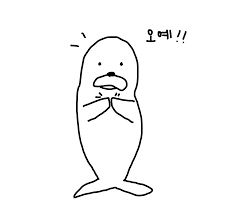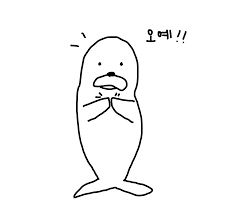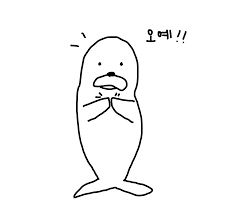